<div style="text-align: center;"><br>
<img src="https://assets-global.website-files.com/62b9d45fb3f64842a96c9686/62d84db4aeb2f6552f3a2f78_Quantinuum%20Logo__horizontal%20blue.svg" width="200" height="200" /></div>

# HPC to H-Series

High-Performance Computing (HPC) and H-Series both require job management support to ensure end-users maximize value for their reservations. Quantum chemistry is one use-case where HPCs and H-Series can be used in tandem. 

* `AVAS`, `PySCF` (classical compute chemistry) are tools that require HPC execution for commercial use-cases. 
* `InQuanto` enables chemistry use-cases to be benefit from **H-Series** execution. 
* `tket` is used to define quantum programs, that use unique **H-Series** features, and to submit these programs for execution.

The `H1-1E` emulator is used to execute the quantum chemistry problem.

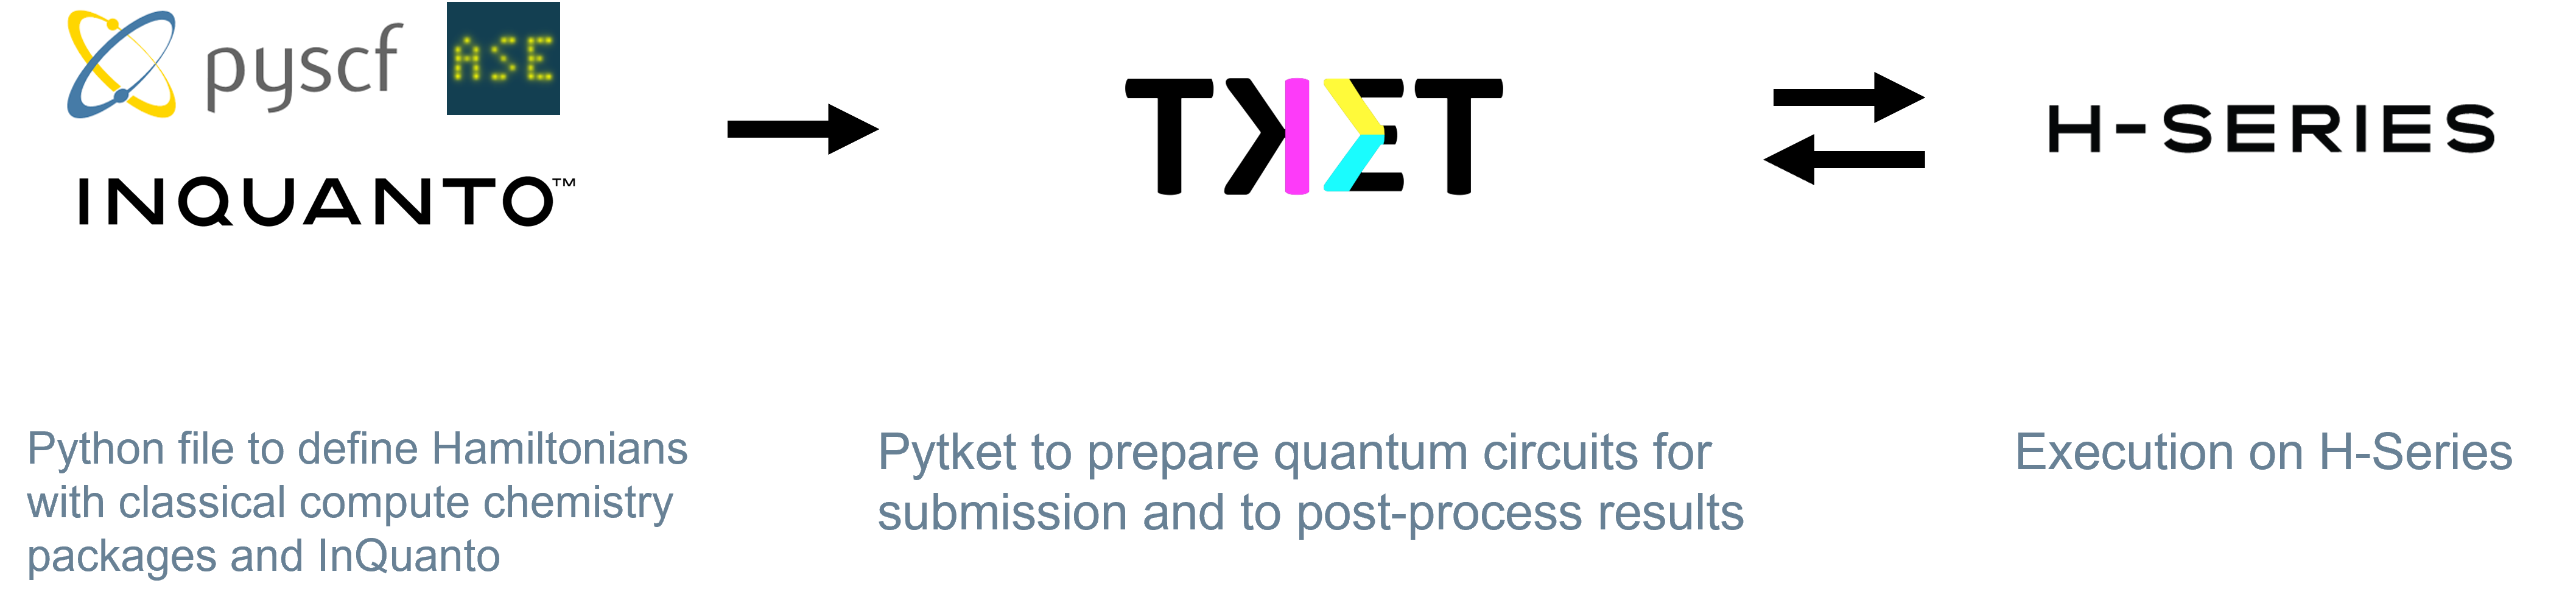

**Contents:**
* [ASE](#ASE)
* [PySCF](#PySCF)
* [InQuanto](#InQuanto)
* [tket](#tket)
* [H-Series](#H-Series)

## ASE

URL: [https://wiki.fysik.dtu.dk/ase/](https://wiki.fysik.dtu.dk/ase/)

The Atomic Simulation Environment (`ASE`) will be used to define the material to simulate on H-Series. The code-cell below defines Oxygen molecule reacting with the surface of a Pd crystal with the FCC structure.

In [1]:
from ase import Atoms
from ase.build import add_adsorbate
from ase.build import fcc111

d=1.3318
h=1.88
o2_mol = Atoms('OXO', positions=[(0., 0.,  0.), (d/2,   0.,   0.) ,(d,   0.,   0.)])
slab_221 =fcc111('Pd', size=(2, 2, 1),vacuum=2*6, a=3.89)
add_adsorbate(slab_221, o2_mol, h, 'bridge', mol_index=1)
slab_221.center()
index_dummy=slab_221.get_chemical_symbols().index('X')
slab_221.pop(index_dummy)

Atom('X', [3.438306723519587, 1.1910643874283202, 12.94], tag=0)

## PySCF

`PySCF` is used to perform classical compute calculation to generate the prequisite data to define the use-case with `InQuanto`.

URL: [https://pyscf.org](https://pyscf.org)

The code-cell below translates:
* the ASE material to a PySCF data-structure
* Applies a chemical specification, a pre-requisite before a classical compute calculation

In [2]:
from pyscf.pbc.tools import pyscf_ase
from pyscf.pbc import gto

geometry = pyscf_ase.ase_atoms_to_pyscf(slab_221)
cell = slab_221.cell

pseudo = "lanl2dz"
basis = {"Pd": "lanl2dz", "O": "lanl2dz"}
df = "GDF"
slab = gto.Cell(
    atom=geometry,
    a=cell,
    multiplicity=1,
    basis=basis,
    pseudo=pseudo,
    charge=0,
    exp_to_discard=0.1,
    dimension=3,
    verbose=3
)
slab.build()

/home/irfankhan/projects/inquanto-docs/.venv/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
ECP lanl2dz not found for  O


Technical parameters controlling the classical-compute resources are specified below:
* Maximum memory to use in PySCF.
* The number of optimisation cycles in the RHF (Restricted Hartree-Fock) SCF (Self-Consistent Field) Calculation.
* Data files to save progress of the calculation.

In [3]:
from pyscf.pbc.scf import RHF

mf = RHF(slab).density_fit()
mf.with_df._cderi_to_save = "./saved_cderi_Pd.h5"
mf.chkfile = "./test_Pd_.chk"

mf.max_cycle = 200
mf.max_memory = 200000
mf.kernel()

/home/irfankhan/projects/inquanto-docs/.venv/lib/python3.10/site-packages/pyscf/pbc/gto/cell.py:120: UserWarning: Function cell.dumps drops attribute a because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -652.784326150177


-652.7843261501766

## InQuanto

`InQuanto` enables use-case definition in the context of H-Series.

URL: [https://inquanto.quantinuum.com](https://inquanto.quantinuum.com)

`InQuanto` will be used to define a qubit Hamiltonian (`pytket.utils.operators.QubitPauliOperator`).

There are three stages:
1. DIY usage of PySCF to generate pre-requisite chemical data.
2. Complete Active-Space (CAS) Definition and Construction
2. Construction of Hamiltonian using `InQuanto` Drivers (Gamma Point Driver)

### Active-Space Selection
AVAS (active valence active space) is an automation technique to construct active orbital spaces for multi-reference and multi-configuration calculations. 

Specifically, molecular orbitals are generated from a targeted set of atomic valence orbitals. 

The molecular orbitals describe all relevant electronic configurations emerging from a targeted set of atomic valence orbitals.

In [5]:
from inquanto.extensions.pyscf import AVAS, ChemistryDriverPySCFGammaRHF

ao_pattern = [
    "O 2s", "O 2p", "O 3p", "O 3s",
    "0 Pd 4d", "0 Pd 5s", "0 Pd 4p", "0 Pd 5p", "0 Pd 5d",
    "1 Pd 4d", "1 Pd 5s", "1 Pd 4p", "1 Pd 5p", "1 Pd 5d",
]

avas = AVAS(
    ao_pattern,
    verbose=4,
    # n_occ=n_occ, # activate this if you would like to chose the number of occupied orbitals instead
    # n_vir=n_vir, # and activate this if you would like to chose the number of virtual orbitals instead
    # frozen=single_occ, # to freeze single occupied orbitals
    threshold=0.4, #0.4
    threshold_vir=0.005, #0.005
    force_halves_active=False
)

The `FromActiveSpace` method is used to define a `$(2e, 2o)$` active-space.

In [6]:
from inquanto.extensions.pyscf import FromActiveSpace

cas_orbs = 2
cas_elec = 2
cas = FromActiveSpace(cas_orbs, cas_elec)

### Hamiltonian Generation

`ChemistryDriverPySCFGammaRHF` applies `AVAS` on the mean-field object prepared with `PySCF`. 

A Hamiltonian, $H$, is generated for the $(2e, 2o)$ active-space defined above and encoded as a sum of Pauli tensor products acting on qubits.

In [7]:
large_driver = ChemistryDriverPySCFGammaRHF.from_mf(mf, frozen=avas.frozenf, transf=avas)
large_driver._mf.verbose = 3

small_driver = large_driver.get_subsystem_driver(frozen=cas)
small_driver._mf.max_cycle=300
small_driver._mf.verbose=3

hamiltonian, space, state = small_driver.get_system()
qubit_hamiltonian = hamiltonian.qubit_encode()


******** AVAS flags ********
aolabels = ['O 2s', 'O 2p', 'O 3p', 'O 3s', '0 Pd 4d', '0 Pd 5s', '0 Pd 4p', '0 Pd 5p', '0 Pd 5d', '1 Pd 4d', '1 Pd 5s', '1 Pd 4p', '1 Pd 5p', '1 Pd 5d']
aolabels_vir = ['O 2s', 'O 2p', 'O 3p', 'O 3s', '0 Pd 4d', '0 Pd 5s', '0 Pd 4p', '0 Pd 5p', '0 Pd 5d', '1 Pd 4d', '1 Pd 5s', '1 Pd 4p', '1 Pd 5p', '1 Pd 5d']
frozen = []
minao = minao
threshold = 0.4
threshold (virtual) = 0.005
with_iao = False
force_halves_active = False
canonicalize = True

** AVAS **
Total number of electrons: 88.0
  Total number of HF MOs  is equal to    90
  Number of occupied HF MOs is equal to  44
reference AO indices for minao ['O 2s', 'O 2p', 'O 3p', 'O 3s', '0 Pd 4d', '0 Pd 5s', '0 Pd 4p', '0 Pd 5p', '0 Pd 5d', '1 Pd 4d', '1 Pd 5s', '1 Pd 4p', '1 Pd 5p', '1 Pd 5d']: [ 1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 41 42 43 44 46 47
 48 49]
(full basis) reference AO indices for {'Pd': 'lanl2dz', 'O': 'lanl2dz'} ['O 2s', 'O 2p', 'O 3p', 'O 3s', '0 Pd 4d', '0 Pd 5s', '0 Pd 4p

ECP lanl2dz not found for  O


Threshold 0.4, threshold_vir 0.005
Active from occupied = 22 , eig [0.87561183 0.92967404 0.95917061 0.96412372 0.98718059 0.9901034
 0.99109815 0.99424308 0.99656162 0.9971665  0.9973078  0.99780096
 0.99910904 0.99914838 0.99950541 0.99955496 1.00035772 1.00068976
 1.00522673 1.0208545  1.02575132 1.05220672]
Inactive from occupied = 22
Active from unoccupied = 29 , eig [0.01380619 0.09724769 0.40248921 0.44377756 0.47672197 0.53728821
 0.72128224 0.83382284 0.91764995 0.92279474 0.92935454 0.96212446
 0.96324652 0.97789976 0.97888544 0.98060957 0.98657785 0.99613564
 0.99939984 1.00002367 1.00014548 1.00171977 1.00282964 1.00358541
 1.02994386 1.03704615 1.05048708 1.14302241 1.21283295]
Inactive from unoccupied = 17
Number of active orbitals 51
# of alpha electrons 22
# of beta electrons 22


A `pandas.DataFrame` can be used to list all the tensor products of Pauli operations and the associated coefficients. 

These tensor products of Pauli will be computed against a state on the quantum computer.

In [8]:
qubit_hamiltonian.df()

,Coefficient,Term,Coefficient Type
0,-652.529748,,<class 'numpy.float64'>
1,0.021011,Z3,<class 'numpy.float64'>
2,0.021011,Z2,<class 'numpy.float64'>
3,0.115917,Z2 Z3,<class 'numpy.float64'>
4,0.009696,X1 X3,<class 'numpy.float64'>
5,-0.011560,X1 Z2 X3,<class 'numpy.float64'>
6,0.009696,Y1 Y3,<class 'numpy.float64'>
7,-0.011560,Y1 Z2 Y3,<class 'numpy.float64'>
8,0.108483,Z1,<class 'numpy.float64'>
9,0.077326,Z1 Z3,<class 'numpy.float64'>


## tket

The `measurement_reduction` method can be used to reduce the number of measurements required. The resulting `MeasurementSetup` object contains: 
* Measurement operations per circuit stored
* Data for post-processing measurement results  

In [9]:
from pytket.partition import (
    measurement_reduction,
    PauliPartitionStrat
)

strat = PauliPartitionStrat.CommutingSets
pauli_strings = [term for term in qubit_hamiltonian._dict.keys()]
measurement_setup = measurement_reduction(pauli_strings, strat)

In [10]:
qubits = list(qubit_hamiltonian.all_qubits)
qubits.sort(key=lambda c: c.index[0])

Preparation of a symbolic circuit, including usage of an arbitrary-angle two-qubit gate, `OpType.ZZPhase`.

The symbol, `s0`, on the circuit is a placeholder for the angle of the gate, `OpType.ZZPhase`. This symbols can be replaced by a python float. 

In [11]:
from pytket.circuit import Circuit
from sympy import Symbol

symbols = [Symbol(f"s{i}") for i in range(1)]

symbolic_circuit = Circuit(len(qubits))
symbolic_circuit.X(0)
symbolic_circuit.H(0).V(2).ZZPhase(symbols[0], 0, 2).H(0).Vdg(2)
symbolic_circuit.H(2).V(0).ZZPhase(-1 * symbols[0], 0, 2).H(2).Vdg(0)
symbolic_circuit.CX(0, 1)
symbolic_circuit.CX(2, 3)

[X q[0]; V q[2]; H q[0]; ZZPhase(s0) q[0], q[2]; H q[0]; Vdg q[2]; V q[0]; H q[2]; ZZPhase(-s0) q[0], q[2]; Vdg q[0]; H q[2]; CX q[0], q[1]; CX q[2], q[3]; ]

In [12]:
from pytket.circuit.display import render_circuit_jupyter

render_circuit_jupyter(symbolic_circuit)

The code-cell below defines a callable object to estimate the optimal parameters of the symbol, `s0`.

In [13]:
from typing import List

from sympy import Symbol
import numpy as np

from pytket.utils.operators import QubitPauliOperator
from pytket.circuit import Circuit


class VariationalProcedure:
    def __init__(
        self, 
        operator: QubitPauliOperator,
        state_circuit: Circuit,
        symbols: List[Symbol]
    ):
        self._operator = operator.to_sparse_matrix().toarray()
        self._circuit = state_circuit
        self._symbols = symbols
    
    def __call__(
        self, 
        parameters: np.ndarray
    ) -> float:
        symbol_dict = {s: p for (s, p) in zip(self._symbols, parameters)}
        circuit = self._circuit.copy()
        circuit.symbol_substitution(symbol_dict)
        statevector = circuit.get_statevector()
        energy = np.vdot(statevector, self._operator.dot(statevector))
        return energy.real

In [14]:
vp = VariationalProcedure(qubit_hamiltonian, symbolic_circuit, symbols)

Initial parameters are defined as a `numpy` array of zeros

In [15]:
initial_parameters = np.zeros(len(symbols))

In [16]:
from scipy.optimize import minimize

result = minimize(vp, initial_parameters, method="L-BFGS-B")

The optimal parameters and optimal value are available as attributes of the output from the `scipy.optimize.minimize` function. The quantum computation will benchmark results against the `result.fun` attribute.

The VQE Energy in Ha (Hartree).

In [17]:
print(f"{result.fun:.7} Ha")

-652.9023 Ha


The optimal parameter as an angle in half-turns

In [18]:
print(f"{result.x[0]:.4} Half-Turns")

-0.1071 Half-Turns


The electronic correlation can be defined as the VQE (Variational Quantum Eigensolver) energy minus the HF (Hartree-Fock) energy

In [19]:
corr = result.fun - small_driver.run_hf()
print(f"{corr:.4} Ha")

-0.0487 Ha


## H-Series

Nexus, Quantinuum's job management platform is used to access H-Series cloud emulators. Nexus enables end-users to better manage the data associated with quantum resource consumption.

To use Nexus, first a project must be created. In the code-cell below, an existing project, `emulator-usage` is retrieved from the nexus server.

In [30]:
from pytket.extensions.nexus import Nexus

nexus = Nexus()
nexus.login()


Login Successful.


In [33]:
project = nexus.get_project_by_name("emulator-usage")

`NexusBackend` is initialized to use the cloud emulator `H1-1E` via `QuantinuumConfig`.

In [35]:
from pytket.extensions.nexus import NexusBackend, QuantinuumConfig

config = QuantinuumConfig(device_name="H1-1E")
backend = NexusBackend(config, project)


Started using project with name: emulator-usage


The expectation value of the Hamiltonian, $H$, will be computed against the state, $| \Psi \rangle$, defined by the the state-preparation circuit using the optimal VQE parameters as the `OpType.ZZPhase` gate angles.

In [21]:
symbol_map = {sym: par for sym, par in zip(symbols, result.x)}
print(symbol_map)

{s0: -0.10705499073654313}


In [22]:
vqe_circuit = symbolic_circuit.copy()
vqe_circuit.symbol_substitution(symbol_map)

The cell below computes the expectation value of the Hamiltonian defined above using the measurement results from the quantum computation and the `MeasurementSetup` defined earlier.

In [23]:
from typing import Dict, Tuple, List

from sympy import Abs

from pytket.circuit import Circuit
from pytket.utils.operators import QubitPauliOperator
from pytket.partition import MeasurementSetup, MeasurementBitMap
from pytket.backends.backendresult import BackendResult

def compute_expectation_paulistring(
    distribution: Dict[Tuple[int, ...], float], bitmap: MeasurementBitMap
) -> float:
    value = 0
    for bitstring, probability in distribution.items():
        value += probability * (sum(bitstring[i] for i in bitmap.bits) % 2)
    return ((-1) ** bitmap.invert) * (-2 * value + 1)

def compute_expectation_value(
    results: List[BackendResult],
    measurement_setup: MeasurementSetup,
    operator: QubitPauliOperator,
) -> float:
    energy = 0
    for pauli_string, bitmaps in measurement_setup.results.items():
        string_coeff = operator.get(pauli_string, 0.0)
        if Abs(string_coeff) > 0:
            value = 0
            for bm in bitmaps:
                index = bm.circ_index
                distribution = results[index].get_distribution()
                value += compute_expectation_paulistring(distribution, bm)
            energy += value * string_coeff / len(bitmaps)
    return energy

The code-cell below uses the state-preparation circuit, $|\Psi \rangle$ and the `MeasurementSetup` instance to generate a collection of measurement circuits. A third argument, `name` is used to define a prefix for each circuit submitted to H-Series via nexus. Each circuit increments an integer to this prefix.

In [37]:
def generate_measurement_circuits(
    state_circuit: Circuit,
    measurement_setup: MeasurementSetup,
    name: str
) -> List[Circuit]:
    circuit: Circuit = state_circuit.copy()
    circuit_list = []
    for i, mc in enumerate(measurement_setup.measurement_circs):
        c = circuit.copy()
        c.append(mc)
        c.name = f"{name}-{i}"
        circuit_list.append(c)
    return circuit_list

In [38]:
meas_circuits = generate_measurement_circuits(vqe_circuit, measurement_setup, "experiment")

Circuit compilation

In [39]:
compiled_circuits = backend.get_compiled_circuits(meas_circuits, optimisation_level=2)

Job Submission

In [40]:
handles = backend.process_circuits(compiled_circuits, n_shots=1000)

Job Status

In [41]:
for h in handles:
    backend.circuit_status(h)

Result Retrieval

In [42]:
results = backend.get_results(handles)

Expectation Value Evaluation

In [43]:
value = compute_expectation_value(results, measurement_setup, qubit_hamiltonian)
print(value)

-652.9002871181781


<div align="center"> &copy; 2024 by Quantinuum. All Rights Reserved. </div>